#import library

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## load & show image

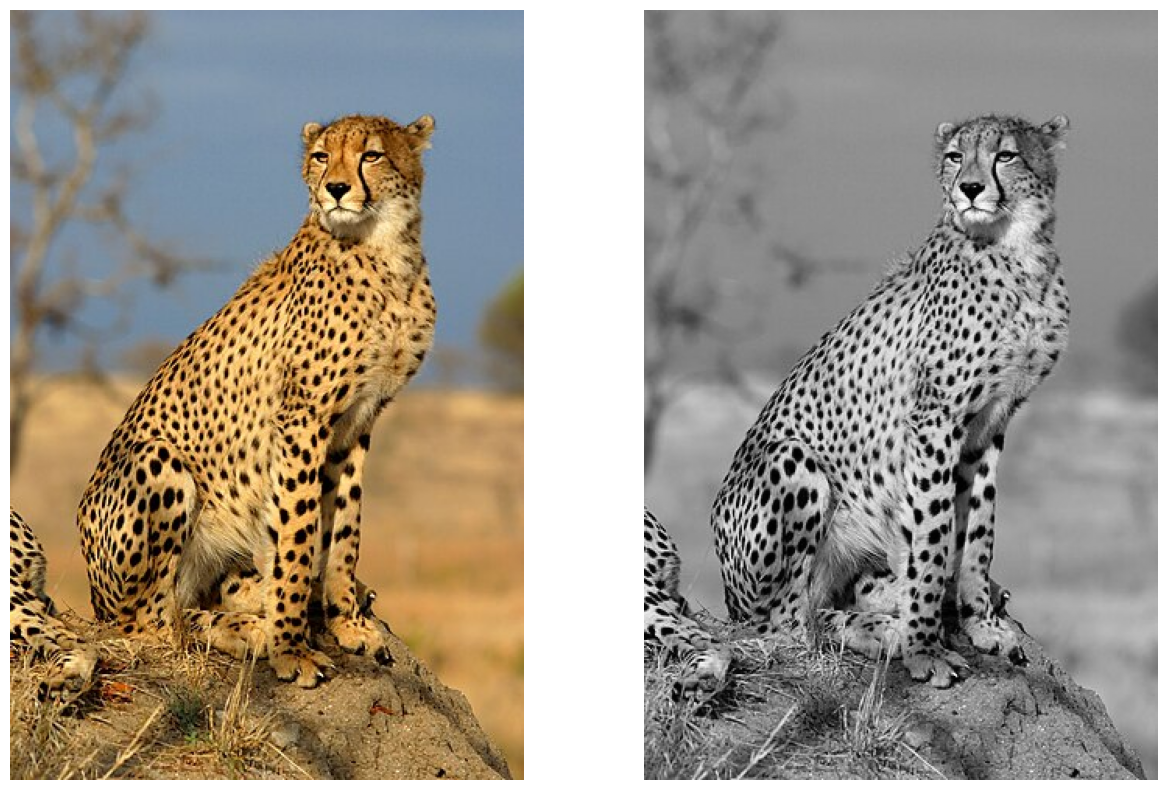

In [3]:
img = np.array(Image.open('TheCheethcat.jpg')).astype(np.uint8)

gray_img = np.round(0.299 * img[:, :, 0] +
                    0.587 * img[:, :, 1] +
                    0.114 * img[:, :, 2]).astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gray_img, cmap='gray')
plt.axis('off')

plt.show()

#Sobel Operator


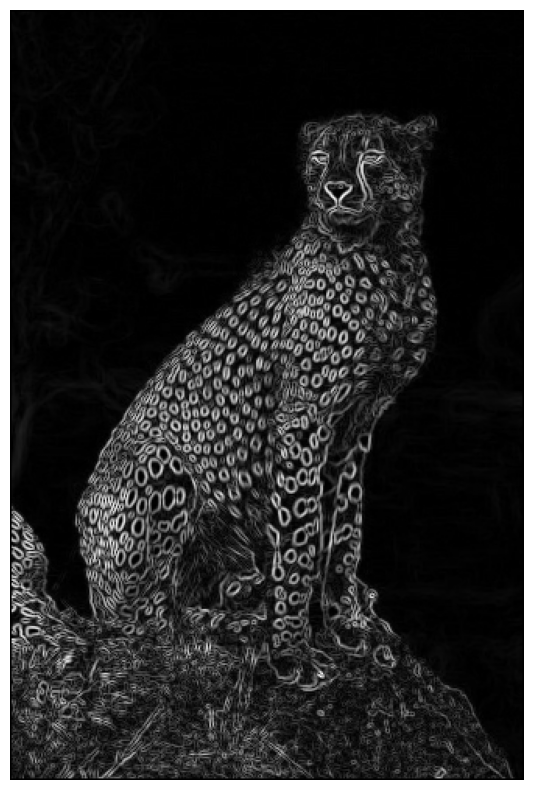

In [4]:
# Sobel Operator
h, w = gray_img.shape

# Define Sobel filters

horizontal = np.array([-1, 0, 1, -2, 0, 2, -1, 0, 1]).reshape(3, 3)
# print(horizontal)
vertical = np.array([-1, -2, -1, 0, 0, 0, 1, 2, 1]).reshape(3, 3)
# print(vertical)

newhorizontalImage = np.zeros((h, w))
newverticalImage = np.zeros((h, w))
newgradientImage = np.zeros((h, w))


for i in range(1, h - 1):
    for j in range(1, w - 1):

        #Apply horizontal Sobel filters using convolution over 3x3 neighborhoods
        horizontalGrad = np.sum(gray_img[i-1:i+2, j-1:j+2] * horizontal)
        # print(horizontalGrad)
        newhorizontalImage[i, j] = abs(horizontalGrad)

        #Apply vertical Sobel filters using convolution over 3x3 neighborhoods
        verticalGrad = np.sum(gray_img[i-1:i+2, j-1:j+2] * vertical)
        # print(verticalGrad)
        newverticalImage[i, j] = abs(verticalGrad)

        # Edge Magnitude
        mag = np.sqrt(verticalGrad ** 2 + horizontalGrad ** 2)
        newgradientImage[i, j] = mag


plt.figure(figsize=(15, 10))
plt.imshow(newgradientImage, cmap='gray')
plt.axis('off')
plt.show()

#Prewitt Operator


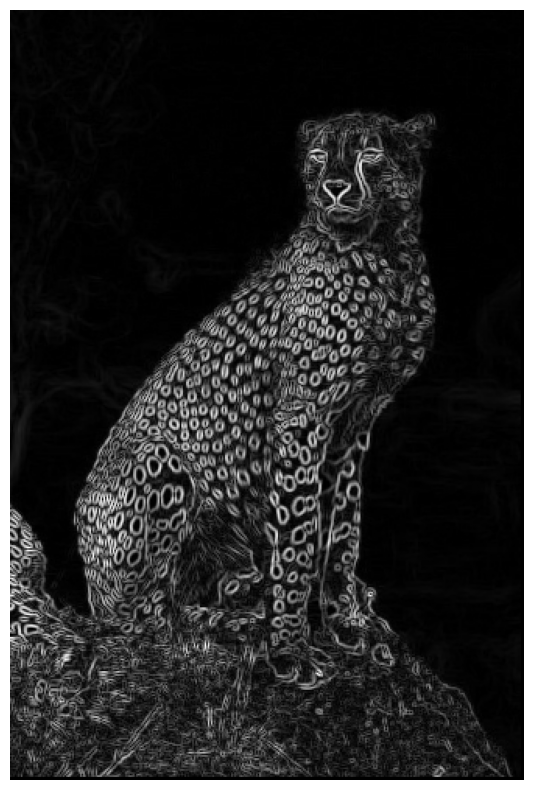

In [5]:
# Prewitt Operator
h, w = gray_img.shape

# Define Prewitt filters
horizontal = np.array([-1, 0, 1, -1, 0, 1, -1, 0, 1]).reshape(3, 3)
vertical = np.array([-1, -1, -1, 0, 0 ,0 , 1, 1, 1]).reshape(3, 3)


newgradientImage = np.zeros((h, w))


for i in range(1, h - 1):
    for j in range(1, w - 1):
        # Similar to Sobel, apply horizontal and vertical Prewitt filters and compute gradient magnitude
        horizontalGrad =np.sum(gray_img[i-1:i+2, j-1:j+2] * horizontal)
        verticalGrad = np.sum(gray_img[i-1:i+2, j-1:j+2] * vertical)

        # Edge Magnitude
        mag = np.sqrt(verticalGrad ** 2 + horizontalGrad ** 2)
        newgradientImage[i - 1, j - 1] = mag

plt.figure(figsize=(15, 10))
plt.imshow(newgradientImage, cmap='gray')
plt.axis('off')
plt.show()

#Canny Operator


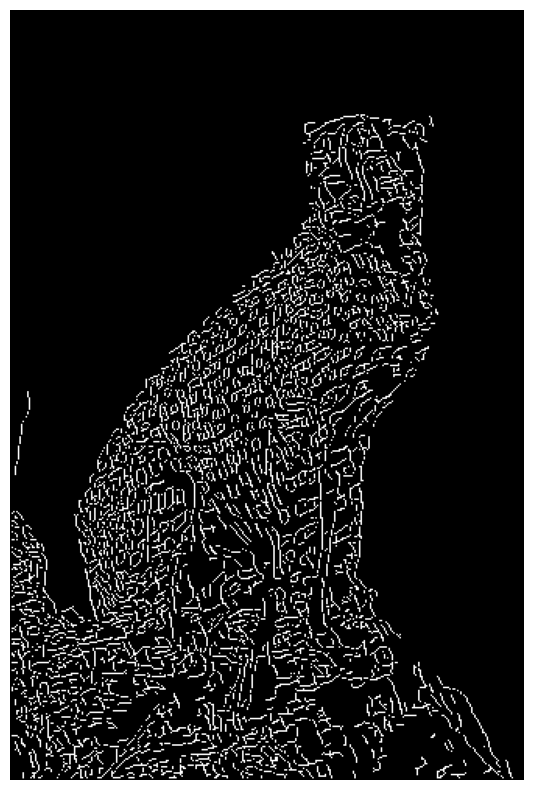

In [9]:
from scipy.ndimage import gaussian_filter, sobel
from collections import deque
gray_img = Image.open('TheCheethcat.jpg').convert('L')
gray_img = np.array(gray_img, dtype=np.float32)

blurred = gaussian_filter(gray_img, sigma=1.4)


dx = sobel(blurred, axis=0)
dy = sobel(blurred, axis=1)
gradient_magnitude = np.hypot(dx, dy)
gradient_direction = np.arctan2(dy, dx)


def non_maximum_suppression(magnitude, direction):
    rows, cols = magnitude.shape
    suppressed = np.zeros((rows, cols), dtype=np.float32)
    # 1. Convert direction to degrees (0-180 range)
    direction = np.rad2deg(direction + 180) % 180
    # print(direction)
     
    # 2. For each pixel, compare magnitude with neighbors along gradient direction
    for i in range(1, rows -1):
        for j in range(1, cols - 1):

            if (0 <= direction[i, j] < 22.5) or (157.5 <= direction[i, j] < 180): # 0 Area
                q = magnitude[i, j + 1]
                r = magnitude[i, j - 1]
                # print(0)
            elif 22.5 <= direction[i, j] < 67.5: # 1 Area
                q = magnitude[i + 1, j + 1] 
                r = magnitude[i - 1, j - 1]
                # print(1)
            elif 67.5 <= direction[i, j] < 112.5: # 2 Area
                q = magnitude[i + 1, j]  
                r = magnitude[i - 1, j]  
                # print(2)
            elif 112.5 <= direction[i, j] < 157.5:  # 4 Area
                q = magnitude[i - 1, j + 1]  
                r = magnitude[i + 1, j - 1]
                # print(3)  
    # 3. Suppress non-maximum values (set to 0)
            # print(direction[i, j])
            # print(r, q, magnitude[i, j])
            if magnitude[i, j] >= q and magnitude[i, j] >= r:
                suppressed[i, j] = magnitude[i, j]
                # print("here")
            # Hint: Check 4 direction bins (0°, 45°, 90°, 135°) and compare with appropriate neighbors

    return suppressed

nms_img = non_maximum_suppression(gradient_magnitude, gradient_direction)


low_threshold = 35
high_threshold = 70

# Apply double thresholding
# Steps:
# 1. Mark strong edges as 255
# 2. Mark weak edges as 75
strong_edges = (nms_img >= high_threshold) * 255
weak_edges = ((nms_img >= low_threshold) & (nms_img < high_threshold)) * 75


def hysteresis(strong, weak):
    rows, cols = strong.shape
    
    directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

    queue = deque(np.argwhere(strong == 255))

    while queue:
        y, x = queue.popleft()

        for dy, dx in directions:
            ny, nx = y + dy, x + dx

            if 0 <= ny < rows and 0 <= nx < cols and weak[ny, nx] == 75:
                weak[ny, nx] = 255
                strong[ny, nx] = 255
                queue.append((ny, nx))

    return strong

edges = hysteresis(strong_edges, weak_edges)


plt.figure(figsize=(15, 10))
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()


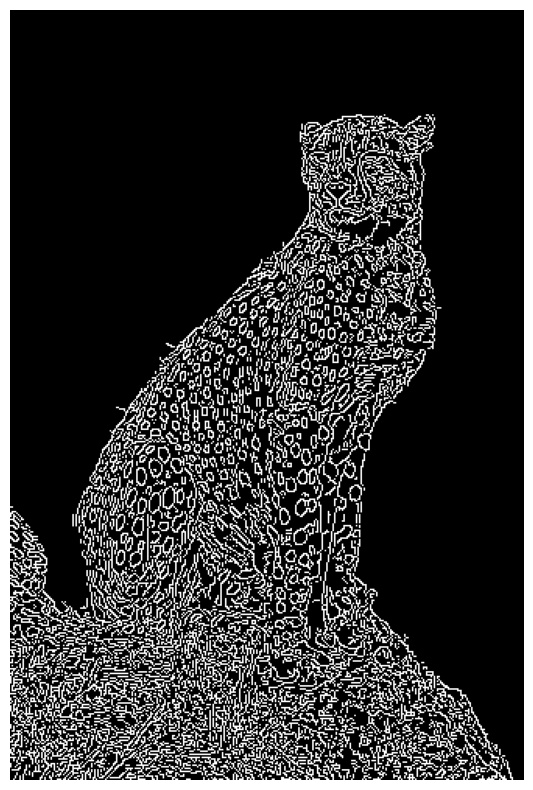

In [10]:
import cv2
import matplotlib.pyplot as plt

# Open the image
img = cv2.imread('TheCheethcat.jpg')


# Apply Canny
# Use cv2.Canny with the following parameters:
# - Low threshold (e.g., 100)
# - High threshold (e.g., 200)
# - Aperture size for Sobel operator (e.g., 3)
edges = cv2.Canny(img, 100, 200, 3)

plt.figure(figsize=(15, 10))
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()